In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.utils import make_grid
from torch.optim import lr_scheduler
from PIL import Image, ImageFile
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from torchvision.datasets import ImageFolder

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK'] = "TRUE"

In [3]:
# hyperparameters
batch_size = 16
in_channels = 3
n_classes = 200
n_epochs = 80
lr = 0.01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device:',device)

device: cuda


In [4]:
def get_train_valid_dataloaders(train_set, valid_set, split_ratio, batch_size, shuffle=True, num_workers=2):
    idx = list(range(len(train_set)))
    
    if shuffle:
        np.random.shuffle(idx)
        
    split = int(np.floor(split_ratio * len(train_set)))
    
    train_idx, valid_idx = idx[split:], idx[:split]
    
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, sampler=train_sampler) #, num_workers=num_workers
    valid_loader = DataLoader(valid_set, batch_size=batch_size, sampler=valid_sampler) #, num_workers=num_workers
    
    return train_loader, valid_loader

In [5]:
transform = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])

In [7]:
train_dataset = ImageFolder(root="CUB_200_2011\CUB_200_2011\images", transform=transform)
train_loader, valid_loader = get_train_valid_dataloaders(train_dataset, train_dataset, 0.2, batch_size=batch_size)

In [8]:
num_images1 = len(train_loader) * train_loader.batch_size
num_images2 = len(valid_loader) * train_loader.batch_size
print(num_images1+num_images2)

11808


In [9]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(images.shape)

torch.Size([16, 3, 224, 224])


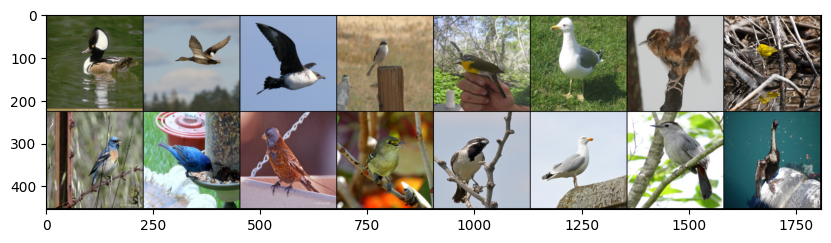

In [10]:
inv_normalize = transforms.Normalize(
    mean=[-0.5/0.5, -0.5/0.5, -0.5/0.5],
    std=[1/0.5, 1/0.5, 1/0.5]
)
    
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(10, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 

image_unorm = inv_normalize(images)
image_grid = make_grid(image_unorm)
imshow(image_grid)

In [11]:
class test1(nn.Module):
    def __init__(self, in_channels, n_classes):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        
#         self.dropout = nn.Dropout(p=0.25)
        self.conv1 = nn.Conv2d(in_channels=self.in_channels, out_channels=96, padding='same', kernel_size=3)
        self.bn1 = nn.BatchNorm2d(96)
        self.max_pool = nn.MaxPool2d(kernel_size=2)
        self.drop1 = nn.Dropout(p=0.4)
        
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=128, padding='same', kernel_size=5)
        self.bn2 = nn.BatchNorm2d(128)
        self.drop2 = nn.Dropout(p=0.1)
        
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=384, padding='same', kernel_size=3)
        self.bn3 = nn.BatchNorm2d(384)
        self.drop3 = nn.Dropout(p=0.2)
        
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=448, padding='same', kernel_size=3)
        self.bn4 = nn.BatchNorm2d(448)
        self.drop4 = nn.Dropout(p=0.3)
        
        self.fc1 = nn.Linear(in_features=87808, out_features=128)
        self.bn5 = nn.BatchNorm1d(128)
        self.drop5 = nn.Dropout(p=0.1)
        
        self.fc2 = nn.Linear(in_features=128, out_features=96)
        self.bn6 = nn.BatchNorm1d(96)
        self.drop6 = nn.Dropout(p=0)
        
        self.fc3 = nn.Linear(in_features=96, out_features=self.n_classes)
                
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.max_pool(x)
        x = self.drop1(x)
        
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.max_pool(x)
        x = self.drop2(x)
        
        x = torch.relu(self.bn3(self.conv3(x)))
        x = self.max_pool(x)
        x = self.drop3(x)
        
        x = torch.relu(self.bn4(self.conv4(x)))
        x = self.max_pool(x)
        x = self.drop4(x)

        x = x.view(x.shape[0], -1)
        x = torch.relu(self.bn5(self.fc1(x)))
        x = self.drop5(x)
        x = torch.relu(self.bn6(self.fc2(x)))
        x = self.drop6(x)
        logit = self.fc3(x)
        return logit

In [12]:
model = test1(in_channels, n_classes).to(device)
print(model)

test1(
  (conv1): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.4, inplace=False)
  (conv2): Conv2d(96, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout(p=0.1, inplace=False)
  (conv3): Conv2d(128, 384, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop3): Dropout(p=0.2, inplace=False)
  (conv4): Conv2d(384, 448, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn4): BatchNorm2d(448, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop4): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=87808, out_features=128, bias=True)
  (bn5): Batc

In [13]:
def train(model, train_loader, device, optimizer, loss_fn):
    model.train()
    train_loss = 0.
    n_corrects = 0
    total = 0
    for idx,(images, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images.float())
        _, predictions = torch.max(outputs, dim=1)
        n_corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*images.size(0)
        current_lr = optimizer.param_groups[0]['lr']

        if (idx+1) % 200 == 0:
            print(idx+1, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d) | lr: %.5f'
                  % (train_loss/(idx+1), 100.*n_corrects/total, n_corrects, total, current_lr))
    train_loss = train_loss/len(train_loader.sampler)

    return train_loss, n_corrects/total

In [14]:
@torch.no_grad()
def validate(model, valid_loader, device, loss_fn):
    model.eval()
    n_corrects = 0
    total = 0
    valid_loss = 0.
    for idx, (images, labels) in enumerate(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
                           
        outputs = model(images.float())
        loss = loss_fn(outputs, labels)
        _, predictions = torch.max(outputs, dim=1)
        n_corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        valid_loss += loss.item()*images.size(0)

    valid_accuracy = n_corrects / total
    print(f"The number of valid images is {total} and the accuracy is {100 * n_corrects/total}")
    
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    return valid_loss, valid_accuracy

In [15]:
model_name = model.__class__.__name__
model_name

'test1'

In [16]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2, min_lr=0.0001)
is_valid_available = True

In [17]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'---Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
best_loss = float('inf')
early_stopping = EarlyStopping(patience=5, verbose=True)

train_loss_list = []
valid_loss_list = []
for epoch in range(1, n_epochs+1):
    training_loss, training_accuracy = train(model, train_loader, device, optimizer, loss_fn)
    valid_loss, valid_accuracy = validate(model, valid_loader, device, loss_fn)
    
    train_loss_list.append(training_loss)
    valid_loss_list.append(valid_loss)

    if scheduler is not None and is_valid_available:
        scheduler.step(valid_loss)
    elif scheduler is not None:
        scheduler.step()

    print(f"Epoch {epoch}/{n_epochs}: training accuracy: {training_accuracy}, valid accuracy: {valid_accuracy}")
    
    early_stopping(valid_loss, model)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), 'bird_best_model.pth')
    
    if early_stopping.early_stop:
        print("Early stopping")
        break
        
print("------best loss:", best_loss)

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label="training loss")
ax.plot(range(1, len(valid_loss_list)+1), valid_loss_list, label="validation loss")
ax.legend()
plt.show()